In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from jupyterplot import ProgressPlot

from nn_sim.data import DataLoader, DatasetNN
from nn_sim.net import layers as nn_layers
from nn_sim.net.layers import (
    Module, Sigmoid, ReLU, IdentityActivation, 
    Step, Softmax, SSELoss, MSELoss, MAELoss, BinaryCrossEntropyLoss,
    CategoricalCrossEntropyLoss, HiddenLayer)
from nn_sim.net.feedfoward import FeedFowardNeuralNetwork
from nn_sim.net.metrics import compute_classification_metrics, confusion_matrix
from nn_sim.net.utils import convert_class_to_1_hot_encoding

In [2]:
def load_idx(filename):
    import gzip
    """Load IDX file format. Returns the data as a numpy array."""
    with gzip.open(filename, 'rb') as f:
        # Read the magic number
        magic = f.read(4)
        data_type = int(magic[2])  # Third byte, data type
        num_dimensions = int(magic[3])  # Fourth byte, number of dimensions

        # Determine data type according to magic number
        if data_type == 8:  # unsigned byte
            dtype = np.uint8
        elif data_type == 9:  # signed byte
            dtype = np.int8
        elif data_type == 11:  # short (2 bytes)
            dtype = np.int16
        elif data_type == 12:  # int (4 bytes)
            dtype = np.int32
        elif data_type == 13:  # float (4 bytes)
            dtype = np.float32
        elif data_type == 14:  # double (8 bytes)
            dtype = np.float64
        else:
            raise ValueError("Unsupported data type")

        # Read the dimensions of the array
        shape = tuple(int.from_bytes(f.read(4), 'big') for _ in range(num_dimensions))

        # Read the data
        data = np.frombuffer(f.read(), dtype=dtype).reshape(shape)
        return data
def load_mnist():
    """Load MNIST data."""
    import os
    folder_path = "./../datasets/mnist"
    
    # Load the datasets
    train_images = load_idx(os.path.join(folder_path, "train-images-idx3-ubyte.gz"))
    train_labels = load_idx(os.path.join(folder_path, "train-labels-idx1-ubyte.gz"))
    test_images = load_idx(os.path.join(folder_path, "t10k-images-idx3-ubyte.gz"))
    test_labels = load_idx(os.path.join(folder_path, "t10k-labels-idx1-ubyte.gz"))

    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = load_mnist()
len(train_images), len(train_labels), len(test_images), len(test_labels)

(60000, 60000, 10000, 10000)

In [4]:
train_images[0].shape, train_images[0].dtype

((28, 28), dtype('uint8'))

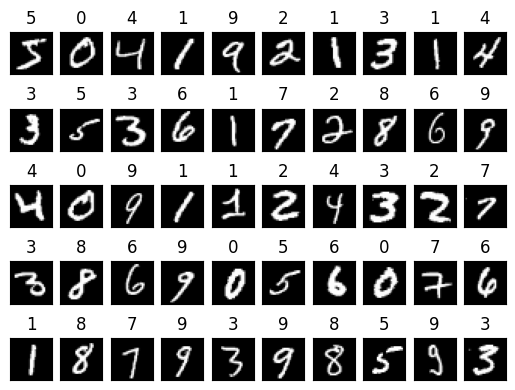

In [5]:
for idx in range(50):
    plt.subplot(5, 10, idx+1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.title(train_labels[idx])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
X_train = np.array(train_images).reshape((-1, 28*28)).astype(np.float32)
Y_train = np.array(train_labels).reshape((-1, 1)).astype(np.int32)
X_test = np.array(test_images).reshape((-1, 28*28)).astype(np.float32)
Y_test = np.array(test_labels).reshape((-1, 1)).astype(np.int32)

In [7]:
Y_train_hot = convert_class_to_1_hot_encoding(Y_train, 10)
Y_test_hot = convert_class_to_1_hot_encoding(Y_test, 10)
print(Y_train_hot.shape, Y_test_hot.shape)

(60000, 10) (10000, 10)


In [ ]:
net = FeedFowardNeuralNetwork(
    28*28, 
    [
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (128, True, Sigmoid()),
        (10, True, Sigmoid()),
    ]
)

loss_func = BinaryCrossEntropyLoss()
learning_rate = 0.1
MAX_EPOCHS = 10000


X = X_train[:50]
Y = Y_train_hot[:50]

X_val = X_train[2000:2100]
Y_val = Y_train_hot[2000:2100]

loss_train = list()
loss_val = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    # train
    net.zero_gradients()
    y_pred = net(X)
    loss = loss_func(y_pred, Y)
    loss_train.append(loss)
    net.backward(y_pred, Y, loss_func)
    
    for layer in net.layers:
        layer.weights = layer.weights - learning_rate * layer.grad_weights
        layer.bias = layer.bias - learning_rate * layer.grad_bias
        
    # val
    net.zero_gradients()
    y_pred = net(X_val)
    loss = loss_func(y_pred, Y_val)
    loss_val.append(loss)


plt.plot(loss_train, label='Train')
plt.plot(loss_val, label='Validation')
plt.show()

y_pred = net(X_val)

print("Train Loss:", loss_train[-1])
print("Validation Loss:", loss_val[-1])
print(compute_classification_metrics(y_pred > 0.5, Y_val))

In [ ]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

conf_matrix = confusion_matrix(y_pred, Y_val, threshold=0.5)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## ADAM

100%|██████████| 2000/2000 [01:08<00:00, 29.13it/s]


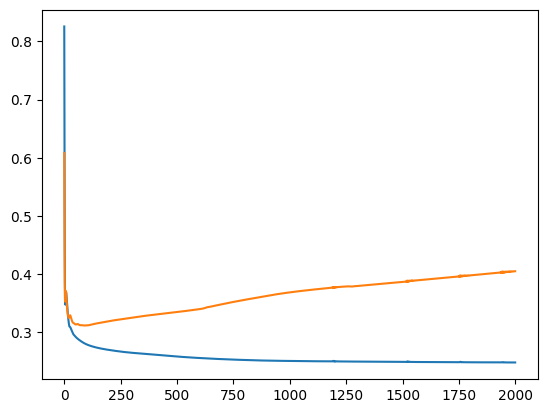

{'accuracy': 0.8866, 'precision': 0.26573426573426573, 'recall': 0.076, 'f1_score': 0.11819595645412129}


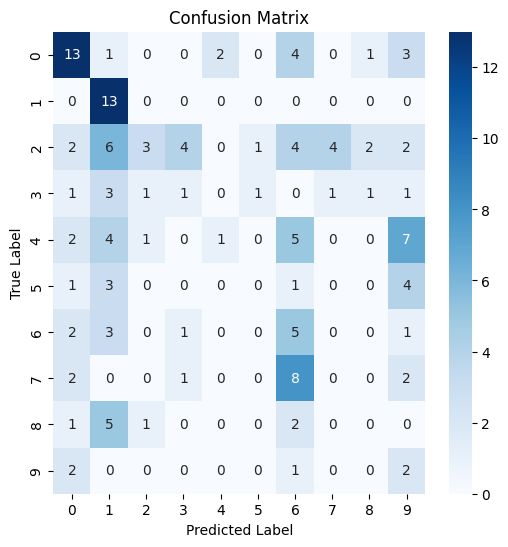

In [9]:
X = X_train[:500]
Y = Y_train_hot[:500]

X_val = X_train[2000:2500]
Y_val = Y_train_hot[2000:2500]

net = FeedFowardNeuralNetwork(
    28*28, 
    [
        (128, True, ReLU()),
        (128, True, ReLU()),
        (128, True, ReLU()),
        (128, True, ReLU()),
        (10, True, Sigmoid()),
        (10, True, Sigmoid()),
        (10, True, Sigmoid()),
    ]
)

for layer in net.layers:
    layer.m_weights = np.zeros_like(layer.weights)
    layer.v_weights = np.zeros_like(layer.weights)
    layer.m_bias = np.zeros_like(layer.bias)
    layer.v_bias = np.zeros_like(layer.bias)


beta1 = 0.90
beta2 = 0.999
epsilon = 1e-7

loss_func = BinaryCrossEntropyLoss()
learning_rate = 0.1
MAX_EPOCHS = 2000

loss_train = list()
loss_val = list()

for epoch in tqdm(range(MAX_EPOCHS)):
    net.zero_gradients()
    y_pred = net(X)
    loss = loss_func(y_pred, Y)
    loss_train.append(loss)
    net.backward(y_pred, Y, loss_func)
    
    t = epoch + 1  # timestep used for bias correction
    
    for layer in net.layers:
        layer.m_weights = beta1 * layer.m_weights + (1 - beta1) * layer.grad_weights
        layer.m_bias = beta1 * layer.m_bias + (1 - beta1) * layer.grad_bias
        
        layer.v_weights = beta2 * layer.v_weights + (1 - beta2) * (layer.grad_weights ** 2)
        layer.v_bias = beta2 * layer.v_bias + (1 - beta2) * (layer.grad_bias ** 2)
        
        m_hat_weights = layer.m_weights / (1 - beta1 ** t)
        m_hat_bias = layer.m_bias / (1 - beta1 ** t)
        v_hat_weights = layer.v_weights / (1 - beta2 ** t)
        v_hat_bias = layer.v_bias / (1 - beta2 ** t)
        
        layer.weights -= learning_rate * m_hat_weights / (np.sqrt(v_hat_weights) + epsilon)
        layer.bias -= learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + epsilon)
        
    # val
    
    net.zero_gradients()
    y_pred = net(X_val)
    loss = loss_func(y_pred, Y_val)
    loss_val.append(loss)
    net.backward(y_pred, Y_val, loss_func)

plt.plot(loss_train)
plt.plot(loss_val)
plt.show()

y_pred = net(X_val)
print(compute_classification_metrics(y_pred > 0.5, Y_val))

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
conf_matrix = confusion_matrix(y_pred, Y_val, threshold=0.5)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()